In [131]:
library(modelr)
library(tidyverse)
library(lubridate)
library(gapminder)
theme_set(theme_classic())
options(repr.plot.width=6, repr.plot.height=4)

### Review
Use the linear model to determine:
1. The average duration of an NYC flight in July.
2. Expected price of a one-carat diamond with a good cut.
3. If the average city gas mileage for Audis is statistically different from the average city gas mileage for Volkswagens.

In [132]:
# Solution

# Lecture 21: Linear regression and model building

### Interpreting the output of `summary(lm(...))`

In [133]:
mdl <- lm(cty ~ class, data = mpg); summary(mdl)


Call:
lm(formula = cty ~ class, data = mpg)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3714 -1.7561 -0.1277  1.0000 14.6286 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      15.4000     1.3024  11.824  < 2e-16 ***
classcompact      4.7277     1.3699   3.451 0.000666 ***
classmidsize      3.3561     1.3796   2.433 0.015759 *  
classminivan      0.4182     1.5708   0.266 0.790307    
classpickup      -2.4000     1.3976  -1.717 0.087304 .  
classsubcompact   4.9714     1.3923   3.571 0.000435 ***
classsuv         -1.9000     1.3539  -1.403 0.161884    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.912 on 227 degrees of freedom
Multiple R-squared:  0.5438,	Adjusted R-squared:  0.5317 
F-statistic:  45.1 on 6 and 227 DF,  p-value: < 2.2e-16


#### Degrees of freedom

In [134]:
df <- (nrow(mpg) - length(coef(mdl))) %>% print

[1] 227


#### Residuals

In [135]:
resids <- add_residuals(mpg, mdl) %>% pluck("resid")
summary(resids)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-6.3714 -1.7561 -0.1277  0.0000  1.0000 14.6286 

#### Residual standard error
The residual sum of squares is 

$$\text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$.

Hence, $\text{RSS}/\rm{df}_e \approx \rm{var}(\epsilon)$.

In [136]:
rss <- sum(resids^2)
sqrt(rss / df)

[1] 2.912303

#### $p$- and $t$-values

In [137]:
2 * pt(3.372, 228, lower.tail = F)

[1] 0.0008765329

#### Multiple $R^2$

$$R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$$

"Fraction of variance explained."

In [138]:
tss = var(mpg$cty) * nrow(mpg)
R2 <- 1 - rss / tss; print(R2)

[1] 0.5457541


#### $\bar{R}^2$, a.k.a adjusted $R^2$

$$\bar{R}^2 = 1 - \frac{\text{RSS}/\rm{df}_e}{\text{TSS}/\rm{df}_t}$$

In [139]:
adj_R2 <- 1 - (rss / (df - 1)) / (tss / (nrow(mpg) - 1)); print(adj_R2)

[1] 0.5316845


#### $F$-test

In [140]:
aov(cty ~ class, mpg) %>% summary

             Df Sum Sq Mean Sq F value Pr(>F)    
class         6   2295   382.5    45.1 <2e-16 ***
Residuals   227   1925     8.5                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Gapminder
The `gapminder` package contains data from [Gapminder](https://www.gapminder.org/), which was popularised by Swedish statistician Hans Rosling. If you don't know about this data or this person, take five minutes and [watch one of his videos](https://www.youtube.com/watch?v=jbkSRLYSojo) before coming to lecture.

In [141]:
# install.packages("gapminder")
library(gapminder)
gapminder %>% print

# A tibble: 1,704 x 6
   country     continent  year lifeExp      pop gdpPercap
   <fct>       <fct>     <int>   <dbl>    <int>     <dbl>
 1 Afghanistan Asia       1952    28.8  8425333      779.
 2 Afghanistan Asia       1957    30.3  9240934      821.
 3 Afghanistan Asia       1962    32.0 10267083      853.
 4 Afghanistan Asia       1967    34.0 11537966      836.
 5 Afghanistan Asia       1972    36.1 13079460      740.
 6 Afghanistan Asia       1977    38.4 14880372      786.
 7 Afghanistan Asia       1982    39.9 12881816      978.
 8 Afghanistan Asia       1987    40.8 13867957      852.
 9 Afghanistan Asia       1992    41.7 16317921      649.
10 Afghanistan Asia       1997    41.8 22227415      635.
# … with 1,694 more rows


To begin with we will focus on how life expectancy varies by year and by country.

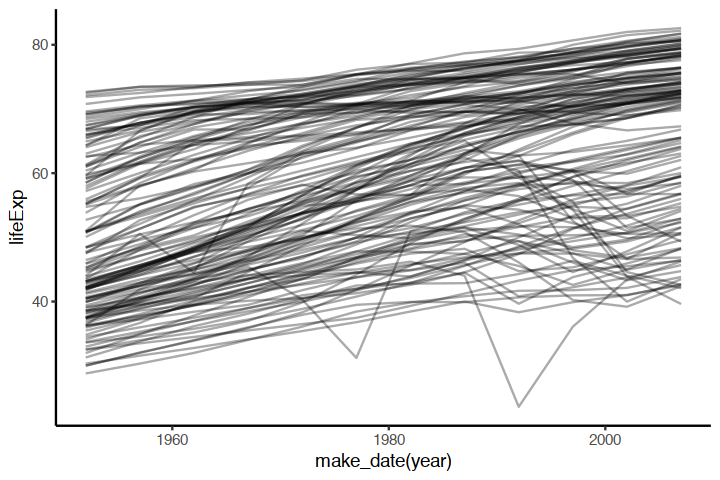

In [142]:
ggplot(gapminder, aes(x = make_date(year), y = lifeExp, group = country))  + 
    geom_line(alpha = 1/3) # + geom_smooth(method="lm")

The regression line shows that overall trend in life expectancy has been upwards over the last fifty years. That's good! But there are some obvious exceptions. To cast those into sharper relief, let's subtract the linear trend from each series.

The linear trend is a good fit most of the non-African and non-Asian countries. However, beginning in the 1990s, a number of African countries have lagged far behind the rest of the world in terms of life expectancy. This is reflected in the negative residuals show in blue on the lower-right portion of this graph.

## Interaction terms
To dig deeper we will want to fit a separate linear model to each country. We want our model to be:

$$\text{lifeExp}_{c}(\text{year}) = \alpha_c + \beta_c \cdot \text{year}.$$

Here $c$ indexes countries. To do this we will add an interaction term:

In [143]:
mdl <- lm(lifeExp ~ country * year, data=gapminder)

To understand what this does, let's turn to the model matrix:

In [144]:
gapminder[1,]
model_matrix(gapminder, lifeExp ~ country * year)[1,]

  country     continent year lifeExp pop     gdpPercap
1 Afghanistan Asia      1952 28.801  8425333 779.4453 

  (Intercept) countryAlbania countryAlgeria countryAngola countryArgentina
1 1           0              0              0             0               
  countryAustralia countryAustria countryBahrain countryBangladesh
1 0                0              0              0                
  countryBelgium ⋯ countryUganda:year countryUnited Kingdom:year
1 0              ⋯ 0                  0                         
  countryUnited States:year countryUruguay:year countryVenezuela:year
1 0                         0                   0                    
  countryVietnam:year countryWest Bank and Gaza:year countryYemen, Rep.:year
1 0                   0                              0                      
  countryZambia:year countryZimbabwe:year
1 0                  0                   

The interaction term creates a separate slope *and* intercept term for every country except one.

Now we can plot the residuals by country, as originally intended:

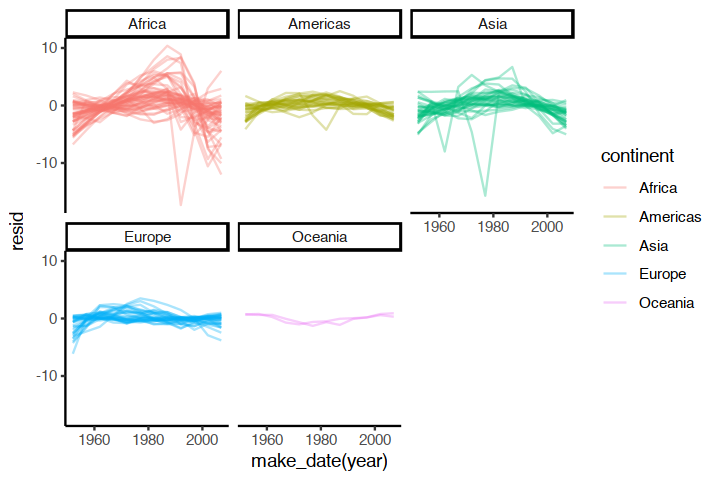

In [145]:
add_residuals(gapminder, mdl) %>% ggplot(aes(x = make_date(year), y = resid, 
                                             group = country, color=continent)) + 
    geom_line(alpha = 1/3)  + facet_wrap(~ continent)

## Measurements of model quality
So far we have looked at residuals to judge how well the models fit. There are other more general measurements of model quality. To help us look at these we will use the `broom` package for turning models into tidy data:

In [146]:
library(broom)


Attaching package: ‘broom’

The following object is masked from ‘package:modelr’:

    bootstrap



The `broom::glance()` function lets us quickly look at a model and judge how well it fits:

In [147]:
nz = gapminder %>% filter(country == "New Zealand")
nz_mod = lm(lifeExp ~ year, data = nz)
glance(nz_mod)

  r.squared adj.r.squared sigma     statistic p.value      df logLik   
1 0.9535846 0.9489431     0.8043472 205.4459  5.407324e-08 2  -13.32064
  AIC      BIC    deviance df.residual
1 32.64128 34.096 6.469743 10         

`glance` prints out some technical measurements of how well the model fits. The basic one is `r.squared`. In the simple linear model this simply measures the square of the correlation between the predictions $\hat{\mathbf{y}}$ and the observations $\mathbf{y}$:

In [148]:
nz %>% add_predictions(nz_mod) %>% summarize(r2 = cor(lifeExp, pred) ** 2)

  r2       
1 0.9535846

To investigate each country individually, we are going to want to fit a linear model separately. For that we'll use a new command called `nest()`. The purpose of `nest()` is to package up our data frame into a bunch of nested data frames:

In [149]:
by_country = gapminder %>% group_by(country, continent) %>% nest %>% print

# A tibble: 142 x 3
   country     continent data             
   <fct>       <fct>     <list>           
 1 Afghanistan Asia      <tibble [12 × 4]>
 2 Albania     Europe    <tibble [12 × 4]>
 3 Algeria     Africa    <tibble [12 × 4]>
 4 Angola      Africa    <tibble [12 × 4]>
 5 Argentina   Americas  <tibble [12 × 4]>
 6 Australia   Oceania   <tibble [12 × 4]>
 7 Austria     Europe    <tibble [12 × 4]>
 8 Bahrain     Asia      <tibble [12 × 4]>
 9 Bangladesh  Asia      <tibble [12 × 4]>
10 Belgium     Europe    <tibble [12 × 4]>
# … with 132 more rows


### Exercise
Use `map()` to run a regression of life expectancy over time for *each* of the 142 countries in this data set. Store the results in a column called `model`.

In [150]:
f <- function(df) lm(lifeExp ~ year, data = df)
gl <- mutate(by_country, model = map(data, f),
             glance = map(model, broom::glance)) %>% 
             unnest(glance) %>% print

# A tibble: 142 x 15
   country continent data  model r.squared adj.r.squared sigma statistic
   <fct>   <fct>     <lis> <lis>     <dbl>         <dbl> <dbl>     <dbl>
 1 Afghan… Asia      <tib… <lm>      0.948         0.942 1.22      181. 
 2 Albania Europe    <tib… <lm>      0.911         0.902 1.98      102. 
 3 Algeria Africa    <tib… <lm>      0.985         0.984 1.32      662. 
 4 Angola  Africa    <tib… <lm>      0.888         0.877 1.41       79.1
 5 Argent… Americas  <tib… <lm>      0.996         0.995 0.292    2246. 
 6 Austra… Oceania   <tib… <lm>      0.980         0.978 0.621     481. 
 7 Austria Europe    <tib… <lm>      0.992         0.991 0.407    1261. 
 8 Bahrain Asia      <tib… <lm>      0.967         0.963 1.64      291. 
 9 Bangla… Asia      <tib… <lm>      0.989         0.988 0.977     930. 
10 Belgium Europe    <tib… <lm>      0.995         0.994 0.293    1822. 
# … with 132 more rows, and 7 more variables: p.value <dbl>, df <int>,
#   logLik <dbl>, AIC <dbl>, BIC

Using the commands we have learned so far, we can apply the glance function to each model in `by_country` in order to extract the $R^2$:

In [151]:
gl = by_country %>% mutate(glance = map(model, glance)) %>% 
                    unnest(glance, .drop = T) %>% arrange(r.squared) %>% print

ERROR: Error in map(model, glance): object 'model' not found


Plotting the resulting data, we see that most countries are fit pretty well by the linear model. But some countries, especially those in Africa, have a very bad fit:

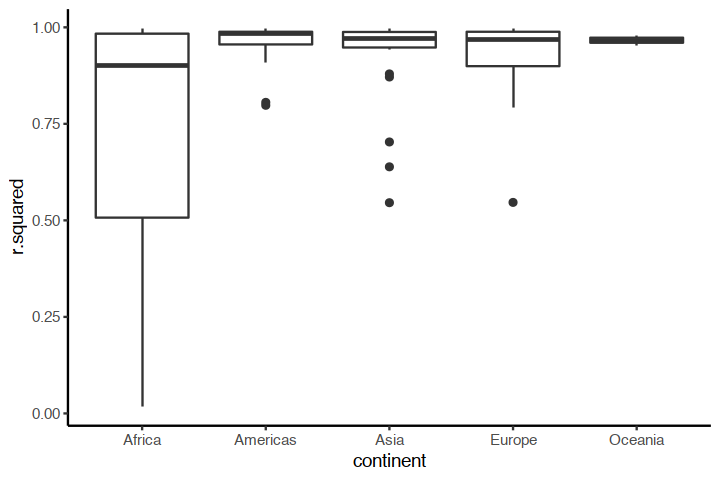

In [152]:
ggplot(gl, aes(x = continent, y = r.squared)) + geom_boxplot()

Let's extract those for further analysis:

Joining, by = c("country", "continent")


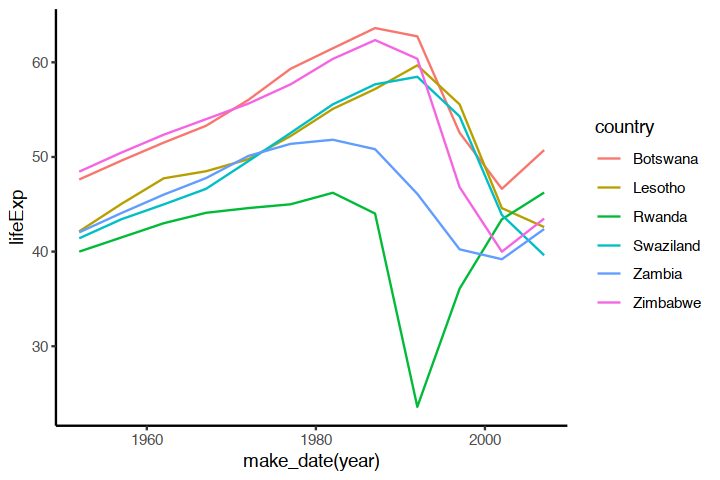

In [153]:
bad_fit = filter(gl, r.squared < 0.25)
gapminder %>% semi_join(bad_fit) %>% 
    ggplot(aes(make_date(year), lifeExp, color = country)) +
    geom_line()